# Wavelet Analysis

In this demo we will learn to apply wavelet analysis. This is a great way to visualize the variability in your time series.

We'll be working with data from the m1244 mooring in the Labrador Sea, which you can get in NetCDF form [here](https://www.dropbox.com/s/4ljiai4zskcxvyf/m1244.nc?dl=0). (This is included in the full distribution of the course materials.)

Many thanks to Jan-Adrian Kallmyr for helping with translating the Matlab tutorial into Python.

As usual, we have to import a few packages.

We'll need to install analytic_wavelet, a reimplementation of my wavelet code into Python by Dan Schwartz.

https://github.com/jonathanlilly/analytic_wavelet

First, if you're using an environment to work in these notebooks, activate that environemnt.  

Next you'll need to install pip and git, if they are not installed already, with

`conda install  -c conda-forge git pip`

Then the analytic_wavelet package is installed direclty from GitHub with

`pip install git+git://github.com/danrsc/analytic_wavelet.git`

In [1]:
import netCDF4 as nc
import xarray as xr    
import spectrum
import analytic_wavelet
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 

#https://docs.python.org/3/library/datetime.html
import time
import datetime

#function for coverting Matlab's datenum into datetime
#from https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.date.fromordinal(int(datenum)) \
           + datetime.timedelta(days=days) \
           - datetime.timedelta(days=366)

#function for converting date to year.fraction
#from https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length  

plt.rcParams["figure.figsize"] = (10,8) #set default figure size

ModuleNotFoundError: No module named 'analytic_wavelet'

# Simple Smoothing Revisited

First we will review simple smoothing of our data.

Generally, the goal of smoothing is to remove high frequencies. This is why we often use the term lowpass, because we want to design a filter through which will let the low frequencies pass through, but which will reject the high ones.

Let's see how the boxcar or rectangle function performs as a lowpass filter. Whereas, as we have seen, the Fourier transform of a Gaussian is also a Gaussian, the Fourier transform of a boxcar is a very bouncy function. 

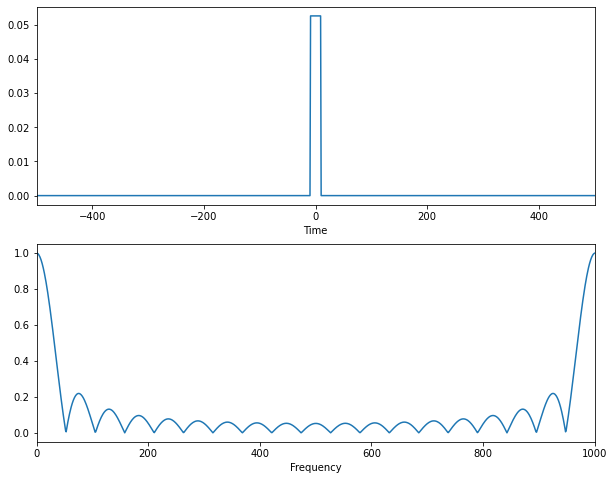

In [2]:
t = np.arange(1001)
t = t-np.mean(t)   
g = 0*t
g[np.argwhere(abs(t)<10)] = 1/19 #this is a 19-point boxcar filter
G = np.fft.fft(g)                

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=False, sharey=False)
ax[0].plot(t,g)
ax[0].set(xlabel="Time")
ax[1].plot(abs(G))
ax[1].set(xlabel="Frequency")
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)

Notice that rather than decaying to zero, the magnitude of the Fourier transform hits zero and bounces back repeatedly. This has undesireable consequences, as we will see. 

Now we will use that boxcar to smooth a dataset. For simplicity, we will use a dataset consisting of white noise. We will look at what happens in time and also in frequency.

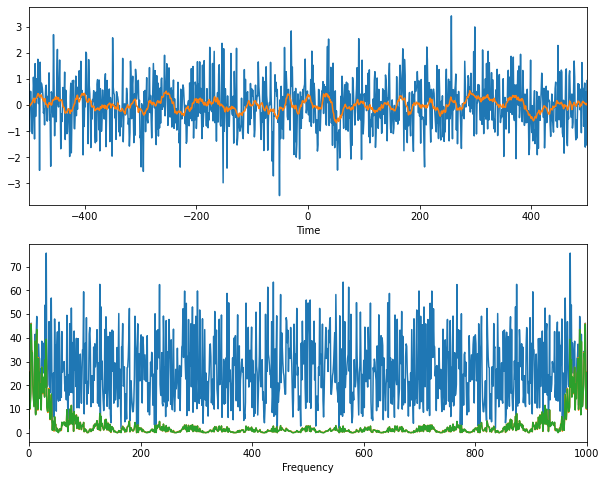

In [3]:
x = np.random.randn(1001)
fx = np.convolve(x,g,mode="same")

X = np.fft.fft(x)  
FX = np.fft.fft(fx) 
G = np.fft.fft(g)

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=False, sharey=False)
ax[0].plot(t,x)
ax[0].plot(t,fx)
ax[0].set(xlabel="Time")

ax[1].plot(abs(X)) 
ax[1].plot(abs(FX))
ax[1].plot(abs(X*G))
ax[1].set(xlabel="Frequency")

ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)

In the time domain, we see that the orange curve is a smoothed version of the blue curve, as expected. However, in the frequency domain, we see something quite odd.

The very lowest frequencies do indeed pass through, as desired. Yet one also sees bumps of energy extending to high frequencies that also passed through. Evidently the boxcar is not a very good lowpass filter! If we are just interested in quickly smoothing the data, it works fine, but if we are interested in looking at the frequency, we see it leaves a strange imprint.

Our time spent studying Fourier theory has an explanation for what is happening:

"Convolution in the time domain is multiplication in the frequency domain!"

When we smooth our time series by the boxcar function, this is accomplished through the convolution operation. Convolving two time seres, as we have stressed repeatedly, is equivalent to multiplying their Fourier transforms.

In fact we have plotted three curves in the lower panel of this plot. The orange curve is the Fourier transform of our smoothed noise time series. The green curve is the Fourier transform of the original noise time series multiplied by the Fourier transform of the boxcar. As you can see, they are virtually identical, as expected from the convolution theorem.

The bumps of the Fourier transform of the boxcar are called “sidelobes” or a “ringing” effect. Such ringing is due to the discontinuous nature of the boxcar. If we want to get rid of this ringing, we need a function that is more smooth in the time domain. This why we use the will typically use the Hanning window for simple smoothing, as it has a nicer Fourier transform.

# Bandpass Filtering

Let's turn our attention now to a new application, the construction of a bandpass rather than lowpass filter.  For this we will again use the deepest velocity at the m1244 mooring. First recall the rotary spectra of this time series.

In [5]:
datadir = "../data/"  #choose this appropriate for your system
filename = "m1244.nc"
ds = xr.open_dataset(datadir+filename) #Load the dataset
ds = xr.Dataset.transpose(ds)  #Enforce the convection that time is in rows

num = ds["num"].data #time in days starting from 0000-00-00
dt = num[1] - num[0] #sample rate in days
cv=ds['u'][:,3].data+1j*ds['v'][:,3].data #complex-valued velocity at 4th depth
Omega = 7.2921159e-5 #rotation rate of the earth in rad / s
fc=2*np.sin(ds['lat']*np.pi*2/360)*Omega*3600*24/(2*np.pi) #Coriolis frequency in cycles / day 

cv_centered = cv - np.mean(cv)
f, p = signal.periodogram(cv_centered, fs=1/dt, return_onesided=False, axis=0)

NW = 16
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv_centered))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
p = np.mean(Sk*eigenvalues, axis=1) * dt

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.loglog(f[f >= 0], p[np.where(f >= 0)])
ax.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax.autoscale(enable=True, tight=True)
fig.tight_layout()
plt.xlabel("Frequency (cycles / day)")
plt.ylabel("Power Spectral Density")

#mark the K1 and M2 tides as well as the inertial frequency
plt.vlines(24/12.4206,ax.get_ylim()[0],ax.get_ylim()[1],linestyles='dotted')
plt.vlines(24/23.9344,ax.get_ylim()[0],ax.get_ylim()[1],linestyles='dotted')
plt.vlines(fc,ax.get_ylim()[0],ax.get_ylim()[1],linestyles='dashed');

We will construct a narrowband filter to remove the whole inertial peak (which includes a contribution from the semidiurnal tide at this latitude).  Let's just run the code and then understand it afterward. 

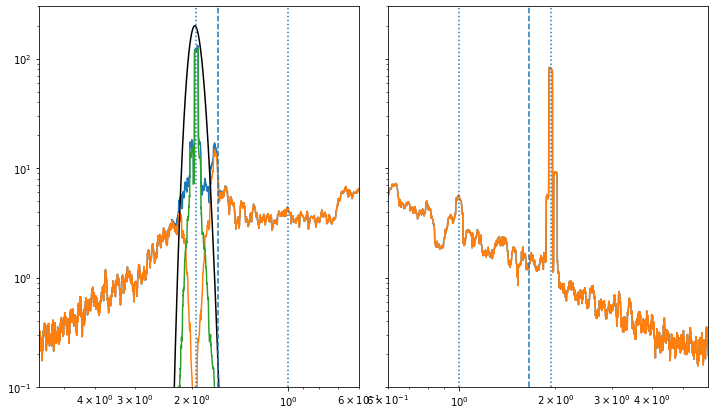

In [5]:
gamma = 3
beta = 100
omega=2*np.pi*1200/len(cv_centered)

#compute the wavelet filter
morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
psi, psif = morse.make_wavelet(len(cv_centered), omega)

#apply wavelet transform using specified wavelet... note two conjugations here
cvo = 1/np.sqrt(2)*np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv_centered), psif, False)).flatten()
cvr = cv_centered - cvo

#compute spectrum of bandpassed time series
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvo, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvo))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
po = np.mean(Sk*eigenvalues, axis=1) * dt

#compute spectrum of residual time series
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvr, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvr))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
pr = np.mean(Sk*eigenvalues, axis=1) * dt

psi, psif = morse.make_wavelet(len(cv_centered), omega)
fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharey=True, gridspec_kw={"wspace": 0.09})

ax[0].loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax[0].loglog(np.abs(f[f < 0]), pr[np.where(f < 0)])
ax[0].loglog(np.abs(f[f < 0]), po[np.where(f < 0)])
ax[0].loglog(f[f >= 0], 50*psif[0][:len(f[f >= 0])]**2, color="black")
ax[0].set_xlim(np.max(f)/10, np.max(f))
ax[0].set_ylim(1e-1, 3e2)
ax[0].invert_xaxis()

ax[1].loglog(f[f >= 0], p[np.where(f >= 0)])
ax[1].loglog(f[f >= 0], pr[np.where(f >= 0)])
ax[1].set_xlim(np.max(f)/10, np.max(f))
ax[1].set_ylim(1e-1, 3e2)

#mark the K1 and M2 tides as well as the inertial frequency
for n in range(2):
   plt.sca(ax[n])
   plt.vlines(24/12.4206,ax[n].get_ylim()[0],ax[n].get_ylim()[1],linestyles='dotted')
   plt.vlines(24/23.9344,ax[n].get_ylim()[0],ax[n].get_ylim()[1],linestyles='dotted')
   plt.vlines(fc,ax[n].get_ylim()[0],ax[n].get_ylim()[1],linestyles='dashed')

Blue is the original time series, orange is the residual (original-bandpassed), green is the bandpassed signal, and black is the wavelet (with a rescaled y-axis for presentational purposes).

As you can see, the negatively-rotating inertial peak has been removed, but the positive spectrum has not been touched at all. This means that the filtered version cvo has effectively isolated the inertial signal.  

The wavelet transform essentially convolves a filter, the wavelet, with the original signal. This means we multiply the wavelet’s Fourier transform by the Fourier transform of the data.  As the wavelet is a *narrowband* signal, this essentially shuts off all frequencies except those inside the band.  Subtracting gives us the original signal with that band removed.  

## Filter Parameter Choices

Let's investigate further the choices of parameters. 

The morse wavelets, constructed by the lines 

`morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)` 

`psi, psif = morse.make_wavelet(len(cv_centered), omega)`

are controlled by two parameters, gamma and beta, together with the filter frequency omega. 

Gamma is a parameter controlling the filter shape, beta is a parameter controlling the filter width in frequency, and omega is the filter center frequency in radians per sample interval.  We will understand all of these more later.

Note, a very important feature of the wavelet filter is that it is one-sided. That is, if we tell it to implement a bandpass filter centred around frequency 10, we mean frequency +10 and not frequency -10.  Only positively phasors will be affected and not negatively rotating phasors.

To cause the wavelet transform to affect negative frequencies, as we wish to do here for the inertial filtering, we conjugate the input signal---which we saw will conjugate its Fourier transform but also flip positive and negative frequencies. Then to put the frequencies back, we also conjugate the output.

Notice also the factor of 1/sqrt(2) in the line

`cvo = 1/np.sqrt(2)*np.conj(analytic_wavelet.analytic_wavelet_transform...)`

This factor arises because there is a factor of sqrt(2) ambiguity in defining the amplitude of a real-valued versus a complex-valued sinusoid.   Essentially we have defined a real-valued sinusoid to have amplitude one, with a consequence being that when we use wavetrans to form a bandpassed version of a complex valued signal, we need to divide by sqrt(2).

I chose the gamma and beta parameters as follows.  Gamma is generally set to 3 for reasons we will see  later.  I found the frequency by noticing that the tidal peak was centered on about the 1200th Fourier frequency after calling plot(spp). The I picked beta by increasing it until it subjectively looked right. 

Here is what the original, bandpassed, and residual time series look like, zoomed in to a 60 day period.  Note the different y-limits for the middle subplot.

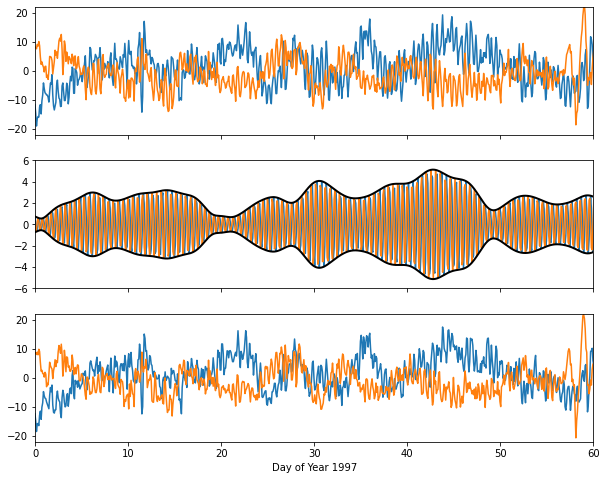

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

numo = 729390  #last day of 1996
ax[0].plot(num-numo, cv_centered.real)
ax[0].plot(num-numo, cv_centered.imag)

ax[1].plot(num-numo, cvo.real)
ax[1].plot(num-numo, cvo.imag)
#plot the envelope of the bandpassed signal
ax[1].plot(num-numo, np.abs(cvo), color="black", linewidth=2)
ax[1].plot(num-numo, -np.abs(cvo), color="black", linewidth=2)

ax[2].plot(num-numo, cvr.real)
ax[2].plot(num-numo, cvr.imag)
plt.xlabel("Day of Year 1997")
plt.setp(ax, xlim=(0,60), ylim=(-22,22))
ax[1].set_ylim(-6,6);

Rather than just lowpassing, we have selectively removed only the inertial peak. A very useful facet of this analysis is that we now have the amplitude of our extracted signal, the inertial band in this case, as plotted with the heavy curve in the second panel. 

We could also now proceed to look at the variance ellipses, statistics, etc, of the inertial band and residual separately. Combining simple statistics with bandpass filtering in this way can be very illuminating.

Next let's remove the tidal peak instead.  This will be done by working with the positive and negative sides separately. However, for reference, code to do the same thing using the real and imaginary parts  is also included, If one uses the real and imaginary parts of the data, there is no factor of sqrt(2).  But since the wavelet is a one-sided bandpass, It will return something complex-valued if we give it a real-valued input. Consequently we need to take the real part of the both output variables.

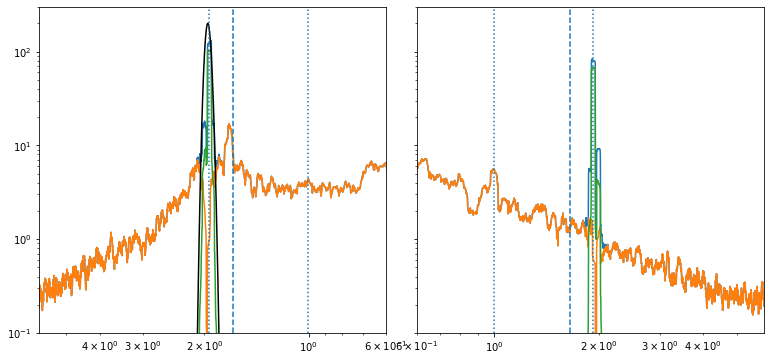

In [7]:
gamma = 3
beta = 500  #choosing a much narrower frequency band this time
omega = 2*np.pi*1200/len(cv_centered)

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
psi, psif = morse.make_wavelet(len(cv_centered), omega)

#compute two bandpassed signals, one for the negative side and one for the positive side
cvo1 = analytic_wavelet.analytic_wavelet_transform(cv_centered, psif, False).flatten()
cvo2 = np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv_centered), psif, False)).flatten()
cvo = 1/np.sqrt(2)*(cvo1 + cvo2)
cvr = cvo - cv_centered

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvo, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvo))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
po = np.mean(Sk*eigenvalues, axis=1) * dt

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvr, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvr))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
pr = np.mean(Sk*eigenvalues, axis=1) * dt

fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True, gridspec_kw={"wspace": 0.09})

ax[0].loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax[0].loglog(np.abs(f[f < 0]), pr[np.where(f < 0)])
ax[0].loglog(np.abs(f[f < 0]), po[np.where(f < 0)])
ax[0].loglog(f[f >= 0], 50*psif[0][:len(f[f >= 0])]**2, color="black")
ax[0].set_xlim(np.max(f)/10, np.max(f))
ax[0].set_ylim(1e-1, 3e2)
ax[0].invert_xaxis()

ax[1].loglog(f[f >= 0], p[np.where(f >= 0)])
ax[1].loglog(f[f >= 0], pr[np.where(f >= 0)])
ax[1].loglog(f[f >= 0], po[np.where(f >= 0)])
ax[1].set_xlim(np.max(f)/10, np.max(f))
ax[1].set_ylim(1e-1, 3e2)

#mark the K1 and M2 tides as well as the inertial frequency
for n in range(2):
   plt.sca(ax[n])
   plt.vlines(24/12.4206,ax[n].get_ylim()[0],ax[n].get_ylim()[1],linestyles='dotted')
   plt.vlines(24/23.9344,ax[n].get_ylim()[0],ax[n].get_ylim()[1],linestyles='dotted')
   plt.vlines(fc,ax[n].get_ylim()[0],ax[n].get_ylim()[1],linestyles='dashed')

We see that the tidal peak has indeed been removed from both sides.

Now that we have a general understanding of the wavelet transform as implementing a one-sided bandpass, we will turn to the wavelet transform itself.

# Wavelet Analysis

Wavelet analysis is an informative visualization tool as well as the jumping-off point for a number of rigorous feature identification methods.  Let's get a feeling for it by returning to the example of the deepest depth at the m1244 mooring.  We'll take a look at the wavelet transforms of the alongstream and cross-stream velocity components we worked with in the earlier labs. 

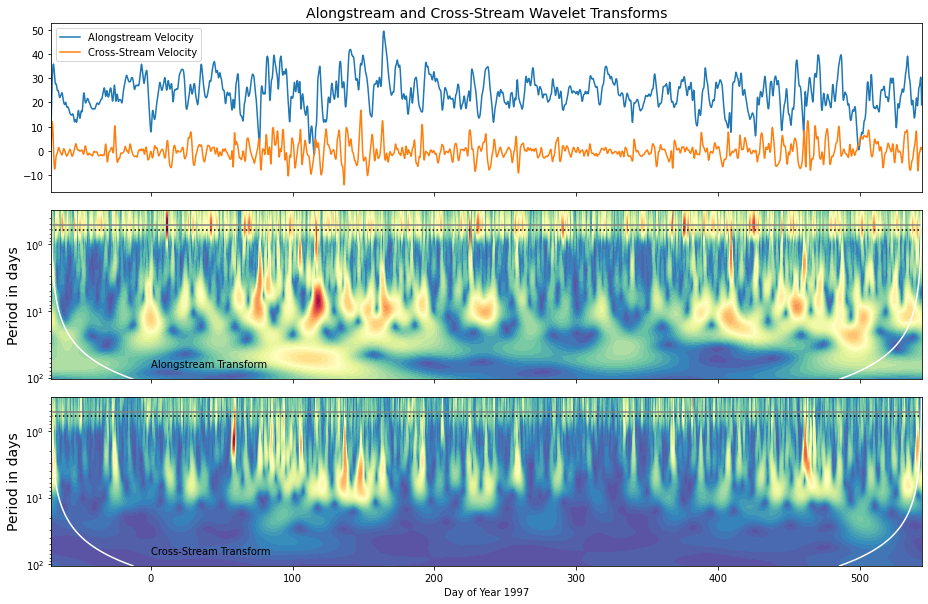

In [8]:
#define functions to return the Coriolis and tidal frequencies
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Args: 
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24;

def tidefreq():
    """
    Eight major tidal frequencies in rad / day.  See Gill (1982) page 335.
    
    Args: 
        None
        
    Returns:
        An array of eight frequencies
    """    
    return 24*2*np.pi/np.array([327.85,25.8194,24.0659,23.9344,12.6584,12.4206,12.0000,11.9673])


dt = num[1] - num[0] #Sample rate in days
cv=ds['u'][:,3].data+1j*ds['v'][:,3].data #complex-valued velocity at 4th depth
phi = np.angle(np.mean(cv))      #Find angle of downstream direction 
cv = cv*np.exp(-phi*1j)  #rotated velocity

gamma = 3
beta = 2

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)  # create morse wavelet object (class instance)
fs = morse.log_spaced_frequencies(num_timepoints=len(cv))  # use object to construct frequency space
psi, psif = morse.make_wavelet(len(cv), fs)  # use object to create a morse wavelet in time and frequency space

wu = analytic_wavelet.analytic_wavelet_transform(cv.real, psif, False)
wv = analytic_wavelet.analytic_wavelet_transform(cv.imag, psif, False)
  
window = signal.windows.hann(24)  # construct Hanning window
cv_smoothed = signal.convolve(cv, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(3, 1, figsize=(13, 8.5), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num-numo, cv_smoothed.real)  # internal function for plotting time series
analytic_wavelet.time_series_plot(ax[0], num-numo, cv_smoothed.imag)  # internal function for plotting time series

cmap = plt.cm.get_cmap("Spectral_r")  # choose colormap
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num-numo, dt/(fs/2/np.pi), wu, 
                                      levels=50,cmap=cmap, vmin=0, vmax=15)
c = analytic_wavelet.wavelet_contourf(ax[2], num-numo, dt/(fs/2/np.pi), wv, 
                                      levels=50,cmap=cmap, vmin=0, vmax=15)

for n in (1,2):
    ax[n].set_ylabel("Period in days", fontsize=14)
    ax[n].invert_yaxis()
    ax[n].set_yscale("log")
    #plot lines at the semidiurnal and tidal frequencies
    ax[n].axhline(2*np.pi/tidefreq()[5], linestyle="solid", color="gray")  #tidefreq()[5] is M2 semidiurnal
    ax[n].hlines(2*np.pi/corfreq(ds["lat"].data),ax[n].get_xlim()[0],ax[n].get_xlim()[1],linestyle=":", color="black")
    
    #plot edge effect lines
    L=dt*2*np.sqrt(2)*np.sqrt(gamma*beta)/fs;
    ax[n].plot(num[0]-numo+L/2,dt*2*np.pi/fs,color="white")
    ax[n].plot(num[-1]-numo-L/2,dt*2*np.pi/fs,color="white")

#fig.colorbar(c, ax=ax[1])
ax[0].set_title("Alongstream and Cross-Stream Wavelet Transforms", fontsize=14)
ax[0].legend(['Alongstream Velocity','Cross-Stream Velocity'])
ax[1].text(0,70,'Alongstream Transform')
ax[2].text(0,70,'Cross-Stream Transform')
plt.xlabel('Day of Year 1997')

fig.tight_layout()

The curving white lines mark the so-called edge effect regions, outside of which the transform should be regarded as untrustworthy.  The simple expression for the edge effect regions that we use here is derived in [this paper](http://dx.doi.org/10.1098/rspa.2016.0776), see Eqn. 2.8 and Figure 3 therein. 

This decomposes the variability as a function of both time and scale, where the latter can be interpreted as a period.  Here, we see three major features. The first is an internal wave / tidal band.  For reference the period of the semidiurnal tide (a half day) has been marked with a solid gray line, and that of the Coriolis frequency (about 14.6 hours at this latitude) has been marked with a dotted black line. A band of energetic variability is seen in both transforms that is localized at shorter periods, or higher frequencies, than the inertial period. 

The second major feature is a series of vertically elongated structures that have their maximum expression in the range of periods from 2 to 10 days. This is a very characteristic appearance of eddy-like variability. In general, wave-like variabilty tends to appear as a horizontal band, where time-localized features such as eddies tend to appear in the wavelet transform as vertically elongated features.  Notice that the eddy band possibly (?) presents some seasonal variability, with elevated levels in February through April in both years. 

A final feature is low-frequency energy, below about a ten day period, which is seen only in the alongstream and not in the cross-stream component.

Thus, the main message here is that the variability seen in the spectrum arises from different structural causes, in particular, a wave-like aspect together with an eddy-like aspect.  This is not apparent in the spectrum as it does not show temporal structure.

It should be pointed out that what we are doing with the wavelet transform at this point is only visualization.  In order to go further and say something quantitative about the variability takes a lot more work. Therefore most of the time we are satisfied with a qualitative or impressionistic interpretation of the wavelet transform. For certain problems, we can create (or apply) very powerful quantitative methods based on the wavelet transform, but we have to proceed carefully because they take a long time to learn. 

The most important thing to note about the wavelet transform is that it is not a property of your time series. It is a *joint function* of your time series and the analyzing wavelet. Therefore, it is essentially to always show the time series together with the transform!  In addition, you should always at least tell the wavelet parameters, if not also show the wavelet.  Showing a wavelet transform without the associated time series is totally meaningless.

For comparison, we'll show the multitaper spectral estimate we created a few days ago.  To facilitate comparision with the wavelet transform, we will use period rather than frequency as the x-axis, and set the limits to match the wavelet transform.

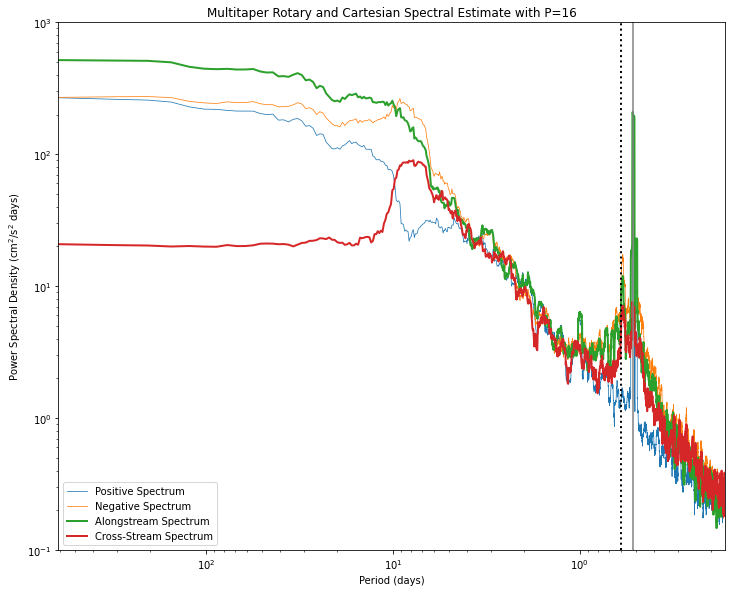

In [9]:
P = 16
psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2*P-1)

Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt

Zk, weights, eigenvalues = spectrum.mtm.pmtm(np.real(cv-np.mean(cv)), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
sxx=2*np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt

Zk, weights, eigenvalues = spectrum.mtm.pmtm(np.imag(cv-np.mean(cv)), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
syy=2*np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt 


fig, ax = plt.subplots(1, 1)
ax.loglog( 1/f[np.where(f>0)],S[np.where(f>0)],linewidth=0.75)#plot positive side
ax.loglog(1/-f[np.where(f<0)],S[np.where(f<0)],linewidth=0.75)#plot negative side
ax.loglog( 1/f[np.where(f>0)],sxx[np.where(f>0)],linewidth=2)#plot downstream
ax.loglog( 1/f[np.where(f>0)],syy[np.where(f>0)],linewidth=2)#plot crossstream
ax.invert_xaxis()

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e-1, 1e3)
fig.tight_layout()

ax.vlines(1/(tidefreq()[5]/2/np.pi),ax.get_ylim()[0],ax.get_ylim()[1],linestyle="-", color="gray")
ax.vlines(1/(corfreq(ds["lat"].data)/2/np.pi),ax.get_ylim()[0],ax.get_ylim()[1],linestyle=":", color="black",linewidth=2)

ax.legend(['Positive Spectrum','Negative Spectrum','Alongstream Spectrum','Cross-Stream Spectrum'],loc='lower left')
plt.xlabel('Period (days)')
plt.ylabel('Power Spectral Density (cm$^2$/s$^2$ days)')
plt.title('Multitaper Rotary and Cartesian Spectral Estimate with P=16');

The Coriolis period and semidiurnal tidal period are marked as they were in the wavelet transform. 

In the spectrum, we see again the three regimes of a small-scale wave band, a sloping isotropic region in the range from 1 day to 10 days period (corresponding to the eddy band in the wavelet transform), and finally a low-frequency region below 10 days period in which the alongstream spectrum levels are substantially elevated relative to the cross-stream levels.  

It should be clear that the wavelet transform and the specta are representing these regimes very differently and are therefore complementary.  The wavelet transform gives us information about what is happening as a function of time, whereas the spectra have superior frequency resolution and are able to, for example, resolve multiple separate lines at high frequencies where the wavelet transform sees only a broad band.    

You might think that if you average horizontally in the wavelet transform, you would obtain an estimate of the Fourier spectrum.  This is true in a sense, however,  an adjustment has to be made for the different ways the Fourier spectrum and wavelet transform are representing variability across different scales or frequencies.  See Section 4a of [this paper](http://dx.doi.org/10.1098/rspa.2016.0776) for details.

Let's take a look at the positive and negative rotary wavelet transforms. 

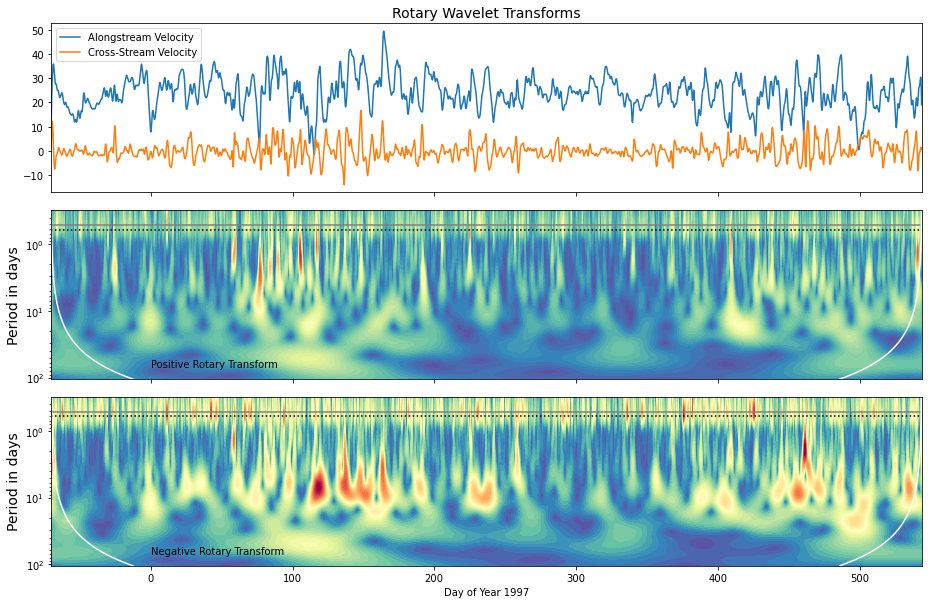

In [10]:
#same as above but forming rotary transforms

gamma = 3
beta = 2

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)  # create morse wavelet object (class instance)
fs = morse.log_spaced_frequencies(num_timepoints=len(cv))  # use object to construct frequency space
psi, psif = morse.make_wavelet(len(cv), fs)  # use object to create a morse wavelet in time and frequency space

wp = analytic_wavelet.analytic_wavelet_transform(cv, psif, False)
wn = analytic_wavelet.analytic_wavelet_transform(np.conj(cv), psif, False)
  
window = signal.windows.hann(24)  # construct Hanning window
cv_smoothed = signal.convolve(cv, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(3, 1, figsize=(13, 8.5), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num-numo, cv_smoothed.real)  # internal function for plotting time series
analytic_wavelet.time_series_plot(ax[0], num-numo, cv_smoothed.imag)  # internal function for plotting time series

cmap = plt.cm.get_cmap("Spectral_r")  # choose colormap
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num-numo, dt/(fs/2/np.pi), wp, 
                                      levels=50,cmap=cmap, vmin=0, vmax=15)
c = analytic_wavelet.wavelet_contourf(ax[2], num-numo, dt/(fs/2/np.pi), wn, 
                                      levels=50,cmap=cmap, vmin=0, vmax=15)

for n in (1,2):
    ax[n].set_ylabel("Period in days", fontsize=14)
    ax[n].invert_yaxis()
    ax[n].set_yscale("log")
    #plot lines at the semidiurnal and tidal frequencies
    ax[n].axhline(2*np.pi/tidefreq()[5], linestyle="solid", color="gray")  #tidefreq()[5] is M2 semidiurnal
    ax[n].hlines(2*np.pi/corfreq(ds["lat"].data),ax[n].get_xlim()[0],ax[n].get_xlim()[1],linestyle=":", color="black")
    
    #plot edge effect lines
    L=dt*2*np.sqrt(2)*np.sqrt(gamma*beta)/fs;
    ax[n].plot(num[0]-numo+L/2,dt*2*np.pi/fs,color="white")
    ax[n].plot(num[-1]-numo-L/2,dt*2*np.pi/fs,color="white")

#fig.colorbar(c, ax=ax[1])
ax[0].set_title("Rotary Wavelet Transforms", fontsize=14)
ax[0].legend(['Alongstream Velocity','Cross-Stream Velocity'])
ax[1].text(0,70,'Positive Rotary Transform')
ax[2].text(0,70,'Negative Rotary Transform')
plt.xlabel('Day of Year 1997')

fig.tight_layout()

We see that the high-frequency band is stronger on the negative rotary side, as expected.  There is also a hint that the energetic eddy-like events extend to somewhat larger scales on the negative rotary side then on the positive rotary side; we see the same hint in the rotary Fourier spectra above.  This could suggest a hypothesis regarding eddy polarity or eddy center cross-stream placement, as both of those will effect the rotation sense of currents of advected eddies.  No significant asymmetry is seen in the rotary transforms at periods longer than 10 days, in keeping with the rotary Fourier spectra.

All in all, this plot appears less informative than the alongstream/downstream plot, although there are other cases where the rotary wavelet analysis is quite revealing.  

Let's see what happens if we change the wavelet transform to try to obtain a high resolution in frequency.  We're looking here at the alongstream/cross-stream transform.

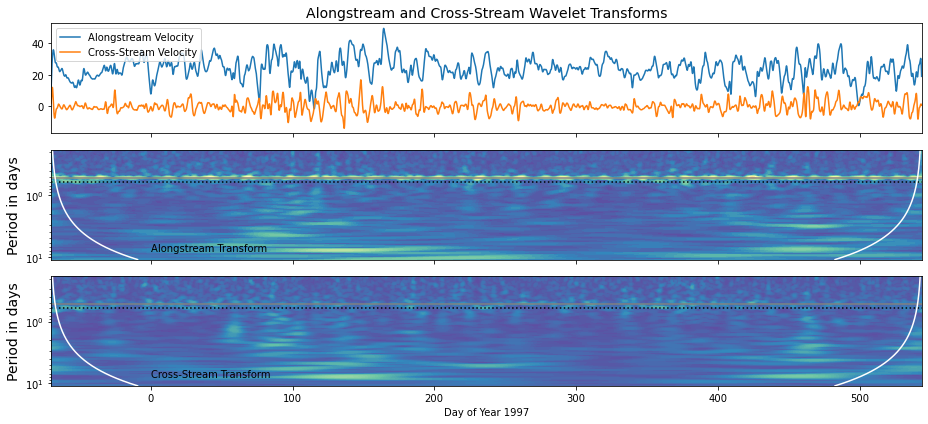

In [11]:
gamma = 3
beta = 200  #<---   all the rest is the same as the first wavelet transform above

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)  # create morse wavelet object (class instance)
fs = morse.log_spaced_frequencies(num_timepoints=len(cv))  # use object to construct frequency space
psi, psif = morse.make_wavelet(len(cv), fs)  # use object to create a morse wavelet in time and frequency space

wu = analytic_wavelet.analytic_wavelet_transform(cv.real, psif, False)
wv = analytic_wavelet.analytic_wavelet_transform(cv.imag, psif, False)
  
window = signal.windows.hann(24)  # construct Hanning window
cv_smoothed = signal.convolve(cv, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(3, 1, figsize=(13, 6), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num-numo, cv_smoothed.real)  # internal function for plotting time series
analytic_wavelet.time_series_plot(ax[0], num-numo, cv_smoothed.imag)  # internal function for plotting time series

cmap = plt.cm.get_cmap("Spectral_r")  # choose colormap
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num-numo, dt/(fs/2/np.pi), wu, 
                                      levels=50,cmap=cmap, vmin=0, vmax=15)
c = analytic_wavelet.wavelet_contourf(ax[2], num-numo, dt/(fs/2/np.pi), wv, 
                                      levels=50,cmap=cmap, vmin=0, vmax=15)

for n in (1,2):
    ax[n].set_ylabel("Period in days", fontsize=14)
    ax[n].invert_yaxis()
    ax[n].set_yscale("log")
    #plot lines at the semidiurnal and tidal frequencies
    ax[n].axhline(2*np.pi/tidefreq()[5], linestyle="solid", color="gray")  #tidefreq()[5] is M2 semidiurnal
    ax[n].hlines(2*np.pi/corfreq(ds["lat"].data),ax[n].get_xlim()[0],ax[n].get_xlim()[1],linestyle=":", color="black")
    
    #plot edge effect lines
    L=dt*2*np.sqrt(2)*np.sqrt(gamma*beta)/fs;
    ax[n].plot(num[0]-numo+L/2,dt*2*np.pi/fs,color="white")
    ax[n].plot(num[-1]-numo-L/2,dt*2*np.pi/fs,color="white")

#fig.colorbar(c, ax=ax[1])
ax[0].set_title("Alongstream and Cross-Stream Wavelet Transforms", fontsize=14)
ax[0].legend(['Alongstream Velocity','Cross-Stream Velocity'])
ax[1].text(0,8,'Alongstream Transform')
ax[2].text(0,8,'Cross-Stream Transform')
plt.xlabel('Day of Year 1997')

fig.tight_layout()

We do see much improved frequency resolution---the wavelet transform exhibits a much narrower stripe in the vicinity of the semidiurnal peak---but this comes at the expense of degraded temporal resolution, wiping out essentially all the temporal structure we could see before.  Note also the much smaller y-axis: we're only resolving up to about 10 days, corresponding to the eddy band identified earlier, because our time series just isn't long enough to support an analysis using these settings.

This is a terrible plot.  Most of what you are seeing here are meaningless artifacts.  Please do make plots like this one.  Its point is simply to show that resolving details of frequency structure is not really what wavelets are good at.  

# Finish

Try making some narrowband filtrations and also wavelet transforms of your data. It is a good idea to also take wavelet transforms of some simple signals of the same length as your data, such as a boxcar and a sinusoid, to get a feeling for how the wavelet transform is representing these.

# The End